C:\Users\vzoppo\AppData\Local\Temp\1\ipykernel_12612\1279670671.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)


F1-score: 0.6998
Accuracy: 0.5839
Precision: 0.5474
Recall: 0.9698


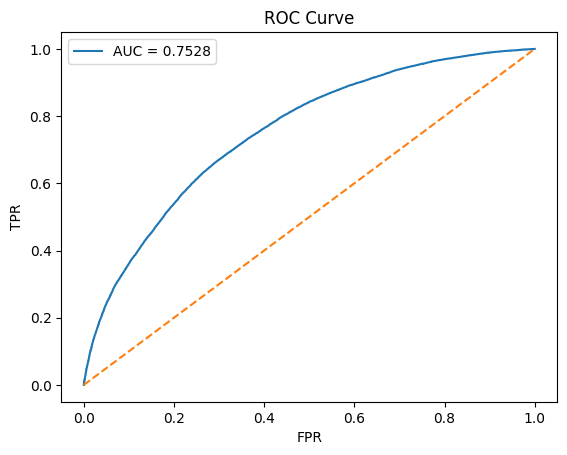

AUC: 0.7528149585550709


In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.nn import SAGEConv
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

train_df = pd.read_csv('../dataset/train_df.csv')
test_df  = pd.read_csv('../dataset/test_df.csv')

for df in [train_df, test_df]:
    df['user_idx'] = df['user_id'].astype('category').cat.codes
    df['prod_idx'] = df['parent_asin'].astype('category').cat.codes

n_users = train_df['user_idx'].max() + 1
n_prods = train_df['prod_idx'].max() + 1

for df in [train_df, test_df]:
    df['prod_idx_shifted'] = df['prod_idx'] + n_users

pos_train = train_df[train_df['exists'] == 1][['user_idx', 'prod_idx_shifted']].values
pos_test  = test_df[test_df['exists'] == 1][['user_idx', 'prod_idx_shifted']].values

def generate_negatives(df, num, n_users, n_prods):
    neg = []
    existing = set(zip(df['user_idx'], df['prod_idx_shifted']))
    while len(neg) < num:
        u = np.random.randint(0, n_users)
        p = np.random.randint(n_users, n_users + n_prods)
        if (u, p) not in existing:
            neg.append([u, p])
    return np.array(neg)

neg_train = generate_negatives(train_df, len(pos_train), n_users, n_prods)
neg_test  = generate_negatives(test_df,  len(pos_test),  n_users, n_prods)

train_edges = np.vstack([pos_train, neg_train])
y_train = np.hstack([np.ones(len(pos_train)), np.zeros(len(neg_train))])

test_edges = np.vstack([pos_test, neg_test])
y_test = np.hstack([np.ones(len(pos_test)), np.zeros(len(neg_test))])

edge_index = torch.tensor(pos_train.T, dtype=torch.long)

train_edges = torch.tensor(train_edges.T, dtype=torch.long)
test_edges = torch.tensor(test_edges.T, dtype=torch.long)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

num_nodes = n_users + n_prods
embedding_dim = 128
x = torch.nn.Embedding(num_nodes, embedding_dim)

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.3)
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm3 = torch.nn.BatchNorm1d(hidden_channels)
    
    def encode(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.batch_norm1(h)
        h = h.relu()
        h = self.dropout(h)
        h = self.conv2(h, edge_index)
        h = self.batch_norm2(h)
        h = h.relu()
        h = self.dropout(h)
        h = self.conv3(h, edge_index)
        h = self.batch_norm3(h)
        h = h.relu()
        return h
    
    def decode(self, h, edges):
        src = h[edges[0]]
        dst = h[edges[1]]
        concat = torch.cat([src, dst], dim=-1)
        h = self.lin1(concat).relu()
        h = self.dropout(h)
        return self.lin2(h).squeeze()

model = LinkPredictor(embedding_dim, 128)
optimizer = torch.optim.AdamW(
    list(model.parameters()) + list(x.parameters()),
    lr=5e-4, weight_decay=1e-5
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

pos_weight_val = (y_train == 0).sum().float() / (y_train == 1).sum().float()
pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

best_f1 = 0
patience_counter = 0
max_patience = 15
best_model_state = None

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    h = model.encode(x.weight, edge_index)
    logits = model.decode(h, train_edges)
    loss = criterion(logits, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(x.parameters()), 1.0)
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        h_val = model.encode(x.weight, edge_index)
        logits_test = model.decode(h_val, test_edges)
        preds = (logits_test.sigmoid() > 0.5).long()
        f1 = f1_score(y_test.numpy(), preds.numpy())
        
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            best_model_state = {
                'model': model.state_dict(),
                'embedding': x.state_dict()
            }
        else:
            patience_counter += 1
        
        if patience_counter >= max_patience:
            break
    
    scheduler.step(loss.item())

if best_model_state is not None:
    model.load_state_dict(best_model_state['model'])
    x.load_state_dict(best_model_state['embedding'])

model.eval()
with torch.no_grad():
    h = model.encode(x.weight, edge_index)
    logits_test = model.decode(h, test_edges)
    probs = logits_test.sigmoid()
    preds = (probs > 0.5).long()

f1 = f1_score(y_test.numpy(), preds.numpy())
accuracy = accuracy_score(y_test.numpy(), preds.numpy())
precision = precision_score(y_test.numpy(), preds.numpy())
recall = recall_score(y_test.numpy(), preds.numpy())

print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

with torch.no_grad():
    h = model.encode(x.weight, edge_index)
    logits_test = model.decode(h, test_edges)
    probs = logits_test.sigmoid().cpu().numpy()
    y_true = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)


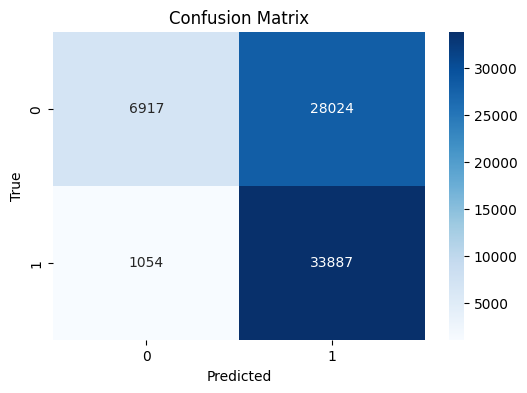

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.numpy(), preds.numpy())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight') 
plt.show()


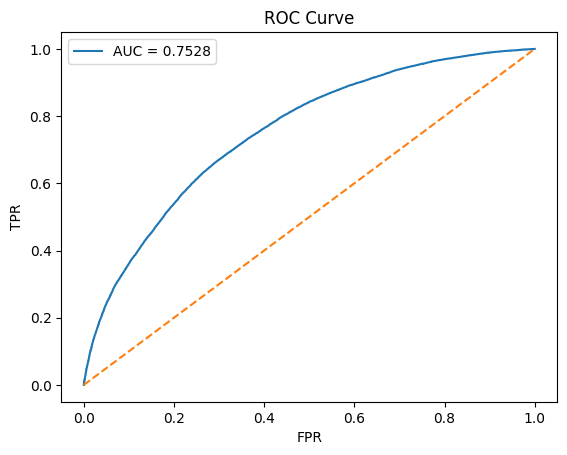

AUC: 0.7528149585550709


In [6]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.savefig("ROC.png", dpi=300, bbox_inches='tight') 
plt.show()

print("AUC:", roc_auc)